In [3]:
import os

# For torch
import torch
import torch.nn as nn
import torch.nn.functional as F

# For geospatial data
from osgeo import gdal
gdal.UseExceptions()
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_bounds
from shapely.geometry import box

# For InVEST
import natcap.invest.habitat_quality as habitat_quality
import natcap.invest.urban_cooling_model as urban_cooling_model
import natcap.invest.urban_nature_access as urban_nature_access
import pandas as pd
import xarray as xr

# For optimization
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import Problem, ElementwiseProblem
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.termination import get_termination

# For pickle
import pickle

In [5]:
base_dir = 'E:/Coding/CNN_InV_ReOrg'
os.chdir(base_dir)

work_dir_hq = 'StudySite/HQWorkDir'
threats_p = 'StudySite/threat.csv'
sensitivity_p = 'StudySite/sensitivity.csv'
work_dir_ucm = 'StudySite/UCMWorkDir'
aoi = 'StudySite/aoi.shp'
et0 = 'StudySite/et0.tif'
pop = 'StudySite/pop.tif'
bio_csv = 'StudySite/Biophysical_ucm_real.csv'
work_dir_una = 'StudySite/UNAWorkDir'
attr_csv = "StudySite/attr_unacsv.csv"
avail_path = "StudySite/avail.tif"
lulc_path = 'StudySite/lulc.tif'
lulc_mod = 'StudySite/lulc_mod.tif'
avail_list_path = "StudySite/valuetable.csv"
norm = 'Normal/normalization_params.npy'
GI_type = [0, 2, 3, 4, 5]
avail_df = pd.read_csv(avail_list_path, sep='\s+', header=None)
inv_result = '0205_res_inv.pkl'
sur_result = '0205_res_sur.pkl'
sur_reeval = '0205_res_sur_real.pkl'
lulc = rxr.open_rasterio(lulc_path).squeeze()
avail = rxr.open_rasterio(avail_path).squeeze()
split_path = 'Fix_Sets'
optmz_site = '7978+.pt' # Path to the optimization site torch input
checkpoint_pth = 'Checkpoints/0204bestUNet.pth'
l = len(avail_df)
input_dir = 'StudySite'
input_tpth = 'StudySite/7978+.pt'

# InVEST model setting

In [ ]:
# Plotting function for testing
def load_and_plot_pt_data(file_path):
    """
    Load a .pt file, reshape the data to (3, 512, 512), and plot each channel in 3 subplots.

    Parameters:
    - file_path: str, path to the .pt file.
    """
    # Load the .pt file with weights_only=True for safety
    data = torch.load(file_path, weights_only=True)
    # Ensure the data has the expected shape
    if data.shape != (3, 1, 512, 512):
        raise ValueError(f"Expected data shape (3, 1, 512, 512), but got {data.shape}")

    # Squeeze the second dimension to reshape the data to (3, 512, 512)
    data = data.squeeze(1)  # Removes the dimension of size 1
    # Plot each channel
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        axs[i].imshow(data[i].numpy(), cmap='viridis')
        axs[i].set_title(f'Channel {i+1}')
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


### Input processing

In [ ]:
# Load sample grids as a GeoDataFrame
samples = gpd.read_file('Sample/Samplefishnets_32618.shp')

def get_expanded_grid(cell, expand_size=1280):
    # Find the center of the cell
    minx, miny, maxx, maxy = cell.bounds
    center_x = (minx + maxx) / 2
    center_y = (miny + maxy) / 2

    # Define the expanded box around the center
    expanded_bounds = box(
        center_x - expand_size,
        center_y - expand_size,
        center_x + expand_size,
        center_y + expand_size
    )

    return expanded_bounds

def process_samples(samples, torc, fid, output_dir, thrt_output_dir, expand_size=1280, threats=[(7, 10), (8, 11), (9, 12)], channel_names = ['lulc', 'et0', 'pop']):
    """
    Load samples, match tensor by FID, expand bounds, and save as GeoTIFF and shapefile.

    Parameters:
    - samples: GeoDataFrame, loaded sample shapefile
    - torc: torch.Tensor, indicating data to convert
    - fid: int, feature ID to match in the sample shapefile
    - output_dir: str, directory to save the output files
    - thrt_output_dir: str, directory to save the threat output files
    - expand_size: int, expansion size for the grid cell
    - threats: list of int or tuple, threat values to extract from LULC
    Returns:
    - None (saves GeoTIFF files and shapefile to the specified directory)
    """
    # Filter the row in samples that matches the `FID`
    sample_row = samples[samples['id'] == fid]

    if len(sample_row) == 0:
        raise ValueError(f"No matching sample found for FID {fid}.")

    # Get the geometry and CRS
    geometry = sample_row.geometry.values[0]
    crs = samples.crs

    # Expand the bounds
    expanded_grid = get_expanded_grid(geometry, expand_size=expand_size)
    minx, miny, maxx, maxy = expanded_grid.bounds

    # Get the corresponding tensor data
    tensor_data = torc.numpy()

    # Check if tensor_data has 3 channels
    if tensor_data.shape[0] != 3:
        raise ValueError("Tensor data must have 3 channels.")

    # Define transform for the raster (GeoTIFF)
    transform = from_bounds(minx, miny, maxx, maxy, tensor_data.shape[1], tensor_data.shape[2])

    # Save each channel as a separate GeoTIFF

    lulc_index = channel_names.index('lulc')
    lulc_data = tensor_data[lulc_index]  # Extract lulc channel data
    for i, channel_name in enumerate(channel_names):
        output_path = f"{output_dir}/{channel_name}.tif"
            # Check if the channel name is 'lulc'
        if channel_name == 'lulc':
            nodata_value = 255
        else:
            nodata_value = None  # No nodata for other channels

        with rasterio.open(
            output_path,
            'w',
            driver='GTiff',
            height=tensor_data.shape[1],
            width=tensor_data.shape[2],
            count=1,  # Single channel per file
            dtype='int32',
            crs=crs,
            transform=transform,
            nodata=nodata_value  # Set nodata value conditionally
        ) as dst:
            dst.write(tensor_data[i].astype(np.int32), 1)

        # print(f"Saved {output_path}")

    # Save the expanded grid as a shapefile
    expanded_grid_gdf = gpd.GeoDataFrame({'id': [fid], 'geometry': [expanded_grid]}, crs=crs)
    output_shapefile_path = f"{output_dir}/aoi.shp"
    expanded_grid_gdf.to_file(output_shapefile_path)

    # print(f"Saved {output_shapefile_path}")

    # Handle threats if provided
    lulc_meta = {
        'driver': 'GTiff',
        'height': lulc_data.shape[0],
        'width': lulc_data.shape[1],
        'count': 1,
        'dtype': 'uint8',
        'crs': crs,
        'transform': transform,
        'compress': 'lzw',
    }
    for threat in threats:
        if isinstance(threat, int):
            # Create binary mask for a single threat value
            binary_mask = np.where(lulc_data == threat, 1, 0).astype(np.uint8)
            out_filename = f"threat_{threat}.tif"
        elif isinstance(threat, tuple):
            # Create binary mask for multiple threat values
            binary_mask = np.isin(lulc_data, threat).astype(np.uint8)
            out_filename = f"threat_{''.join(map(str, threat))}.tif"
        else:
            raise ValueError("Threats must be a list of integers or tuples of integers.")

        # Write the binary mask to a new raster file
        out_path = f"{thrt_output_dir}/{out_filename}"
        with rasterio.open(out_path, 'w', **lulc_meta) as dst:
            dst.write(binary_mask, 1)

        # print(f"Saved binary raster: {out_path}")


In [ ]:
fid = 108
test = f"Prosd/{fid}.pt"
torc = torch.load(test, weights_only=True).squeeze(1)
output_dir = "InVEST_Model/MainInputs"
thrt_output_dir = "InVEST_Model/HabitatQuality"
process_samples(samples, torc, fid, output_dir, thrt_output_dir)

### InVEST functions

In [ ]:

def hq(lulc, work_dir, threats_p, sensitivity_p):
    '''
    lulc: string, path to land use land cover raster
    threats: list of ints, each int is a threat, this should contain transportation network
    threat_dir: string, path to directory with threat rasters, including road networks
    output_dir: string, path to output directory
    file_prefix: string, prefix for output files
    '''
    suffix = 'test'
    # run the habitat quality model
    habitat_quality.execute({ 'lulc_cur_path': lulc,
                 'threats_table_path': threats_p,
                 'half_saturation_constant': 0.345,
                 'results_suffix': suffix,
                 'workspace_dir': work_dir,
                 'sensitivity_table_path': sensitivity_p})

    # read the output raster and get the max value
    hq_res = rxr.open_rasterio(os.path.join(work_dir, f'quality_c_{suffix}.tif'))
    hq_washed = hq_res.where(hq_res != hq_res.rio.nodata)
    mean_value = hq_washed.mean().values.item()
    # maximize the mean value, minimize the negative of the mean
    return - mean_value


def ucm(lulc_path, work_dir_ucm, aoi_p, ref_eto_p, bio_p):
    """
    Run the Urban Cooling Model from InVEST.

    Parameters:
    - lulc_path: str, path to the LULC raster input.
    - work_dir: str, directory to save the model outputs.
    Returns:
    - float, mean value of the output map.
    """
    suffix = 'test'
    args = {
        'workspace_dir': work_dir_ucm,
        'results_suffix': suffix,
        'lulc_raster_path': lulc_path,
        't_ref': 22.6,
        'ref_eto_raster_path': ref_eto_p,
        'aoi_vector_path': aoi_p,
        'biophysical_table_path': bio_p,
        'green_area_cooling_distance': 450.0,
        't_air_average_radius': 200.0,
        'uhi_max': 2.06,
        'do_energy_valuation': False,
        'do_productivity_valuation': False,
        'cc_method': 'factors',
        'cc_weight_shade': 0.6,
        'cc_weight_albedo': 0.2,
        'cc_weight_eti': 0.2,
    }

    urban_cooling_model.execute(args)
    output_map_path = f"{work_dir_ucm}/hm_{suffix}.tif"
    ucm_res = rxr.open_rasterio(output_map_path)
    ucm_washed = ucm_res.where(ucm_res != ucm_res.rio.nodata)
    # maximize the mean value, minimize the negative of the mean
    mean_value = ucm_washed.mean().values.item()
    return - mean_value


def una(lulc_path, work_dir_una, pop_p, aoi_p, attr_csv):
    """
    Run the Urban Nature Access Model from InVEST.

    Parameters:
    - lulc_path: str, path to the LULC raster input.
    - output_path: str, directory to save the model outputs.
    - population_raster_path: str, path to the population raster input.
    - admin_boundaries_vector_path: str, path to the administrative boundaries vector input.
    - lulc_attribute_table: str, path to the LULC attribute table CSV.
    Returns:
    - float, mean value of the output map.
    """
    suffix = 'test'
    args = {
        'workspace_dir': work_dir_una,
        'results_suffix': suffix,
        'lulc_raster_path': lulc_path,
        'admin_boundaries_vector_path': aoi_p,
        'lulc_attribute_table': attr_csv,
        'population_raster_path': pop_p,
        'urban_nature_demand': 45.0,  # Example value
        'decay_function': 'dichotomy',
        'search_radius_mode': 'radius per urban nature class',
        'aggregate_by_pop_group': False,
    }
    urban_nature_access.execute(args)
    output_map_path = f"{work_dir_una}/output/urban_nature_balance_totalpop_{suffix}.tif"
    una_res = rxr.open_rasterio(output_map_path)
    una_washed = una_res.where(una_res < 0, drop=True)
    # ignore negative inf
    una_washed = una_washed.where(una_washed != -np.inf, 0)
    # maximize the sum of negative values, minimize the negative of the sum
    sum_value = una_washed.fillna(0).sum().item()
    return - sum_value



In [ ]:
hq_test = hq(lulc_path, work_dir_hq, threats_p, sensitivity_p)
ucm_test = ucm(lulc_path, work_dir_ucm, aoi, et0, bio_csv)
una_test = una(lulc_path, work_dir_una, pop, aoi, attr_csv)
print(hq_test, ucm_test, una_test)

# Optimization

### Utility

In [ ]:
# Function to modify LULC based on availability and GI type
def modify_lulc(lulc, avail, avail_df, GI_type, x_prime):
    avail_values = avail_df.iloc[:, 0].tolist()
    avail_np = avail.values
    lulc_np = lulc.values.copy() 
    x = np.array([GI_type[i] for i in x_prime])
        # Iterate over each group and modify lulc accordingly
    for i, avail_val in enumerate(avail_values):
        gi_val = x[i]
        if gi_val != 0:
            # Update lulc where the avail mask equals the current group value
            lulc_np[avail_np == avail_val] = gi_val
    modified_lulc = xr.DataArray(
            lulc_np,
            coords=lulc.coords,
            dims=lulc.dims,
            attrs=lulc.attrs
        )
    modified_lulc.rio.to_raster('StudySite/lulc_mod.tif')
    # count the number of pixels that have been modified
    modified_pixels = np.sum(modified_lulc != lulc).item()
    # print(f"Modified {modified_pixels} pixels.")
    return modified_pixels

# Function to modify LULC array based on availability and GI type
def modify_array(lulc, avail, avail_df, GI_type, x_prime):
    avail_values = avail_df.iloc[:, 0].tolist()
    avail_np = avail.values
    lulc_np = lulc.values.copy() 
    x = np.array([GI_type[i] for i in x_prime])
        # Iterate over each group and modify lulc accordingly
    for i, avail_val in enumerate(avail_values):
        gi_val = x[i]
        if gi_val != 0:
            # Update lulc where the avail mask equals the current group value
            lulc_np[avail_np == avail_val] = gi_val
    modified_lulc = xr.DataArray(
            lulc_np,
            coords=lulc.coords,
            dims=lulc.dims,
            attrs=lulc.attrs
        )
    # modified_lulc.rio.to_raster('StudySite/lulc_mod.tif')
    # count the number of pixels that have been modified
    modified_pixels = np.sum(modified_lulc != lulc).item()
    # print(f"Modified {modified_pixels} pixels.")
    return modified_lulc, modified_pixels


### InVEST based optimization

In [ ]:
class LULCOptimizationProblem(ElementwiseProblem):
    def __init__(self, avail_df, lulc, avail, GI_type, 
                 work_dir_hq, threats_p, sensitivity_p, 
                 work_dir_ucm, aoi, et0, bio_csv):
        
        self.avail_df = avail_df
        self.lulc = lulc
        self.avail = avail
        self.GI_type = GI_type
        self.work_dir_hq = work_dir_hq
        self.threats_p = threats_p
        self.sensitivity_p = sensitivity_p
        self.work_dir_ucm = work_dir_ucm
        self.work_dir_una = work_dir_una
        self.attr_csv = attr_csv
        self.aoi = aoi
        self.pop = pop
        self.et0 = et0
        self.lulc_mod = lulc_mod
        self.bio_csv = bio_csv

        super().__init__(n_var=l, n_obj=4, 
                         n_constr=0, xl=0, xu=4, type_var=int)

    def _evaluate(self, x, out, *args, **kwargs):
        # Number of solutions
        x_prime = x
        num_modified = modify_lulc(self.lulc, self.avail, self.avail_df, self.GI_type, x_prime)
        # Objective values for each solution
        f1 = hq(self.lulc_mod, self.work_dir_hq, self.threats_p, self.sensitivity_p)
        f2 = ucm(self.lulc_mod, self.work_dir_ucm, self.aoi, self.et0, self.bio_csv)
        f3 = una(self.lulc_mod, self.work_dir_una, self.pop, self.aoi, self.attr_csv)
        f4 = num_modified

        # Set the objective values
        out["F"] = [f1, f2, f3, f4]

# Initialize problem instance
problem = LULCOptimizationProblem(
    avail_df=avail_df,
    lulc=lulc,
    avail=avail,
    GI_type=GI_type,
    work_dir_hq=work_dir_hq,
    threats_p=threats_p,
    sensitivity_p=sensitivity_p,
    work_dir_ucm=work_dir_ucm,
    aoi=aoi,
    et0=et0,
    bio_csv=bio_csv,
)

# NSGA-II Algorithm setup
algorithm = NSGA2(
    pop_size=50,
    sampling=IntegerRandomSampling(),
    crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
    mutation=PM(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
    eliminate_duplicates=True
)

# Termination criterion
termination = get_termination("n_gen", 200)

In [ ]:
# Optimize the problem
res = minimize(
    problem,
    algorithm,
    termination,
    seed=1,
    save_history=True,
    verbose=True
)
# Save the results
with open(inv_result, 'wb') as f:
    pickle.dump(res, f)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       50 |     29 |             - |             -
     2 |      100 |     43 |  0.0714285714 |         ideal
     3 |      150 |     50 |  0.1528082837 |         ideal
     4 |      200 |     50 |  0.0239678760 |         ideal
     5 |      250 |     50 |  0.0811704118 |         ideal
     6 |      300 |     50 |  0.0268736936 |         ideal
     7 |      350 |     50 |  0.0244116695 |         nadir
     8 |      400 |     50 |  0.0169260833 |         ideal
     9 |      450 |     50 |  0.0757139114 |         ideal
    10 |      500 |     50 |  0.0044141607 |         ideal
    11 |      550 |     50 |  0.0064535919 |         ideal
    12 |      600 |     50 |  0.0175032175 |         ideal
    13 |      650 |     50 |  0.0100233625 |         nadir
    14 |      700 |     50 |  0.0556635877 |         ideal
    15 |      750 |     50 |  0.0476190476 |         ideal
    16 |      800 |     50 |  0.0206578210 |            

### Visualization (InVEST-based)

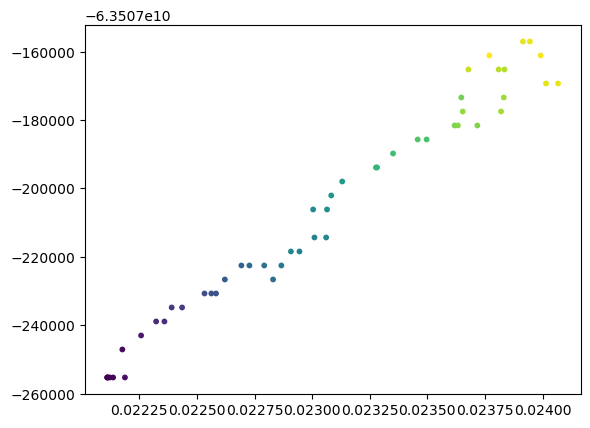

In [ ]:
# visualize the pareto 
import matplotlib.pyplot as plt
import numpy as np
import pickle
# Load the results from the file
with open(inv_result, 'rb') as f:
    res_load = pickle.load(f)

FI = res_load.F * [-1, -1, -1, 1] # Invert the first three objectives 
fig = plt.figure()
plt.scatter(FI[:,0], FI[:,2], c=FI[:,1], s=10)
plt.show()

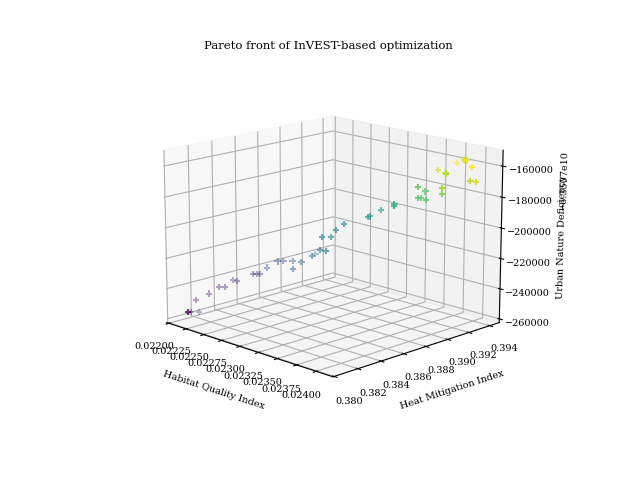

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

%matplotlib widget
# Sample data, replace F with your actual data
# change the font into cmu serif

matplotlib.rcParams['font.family'] = 'serif'
# font size
matplotlib.rcParams.update({'font.size': 7})

# Extracting the three dimensions
x = FI[:, 0]
y = FI[:, 1]
z = FI[:, 2]
t = FI[:, 3]

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the scatter plot
ax.scatter(x, y, z, c=t, marker='+')
# ax.scatter(x0, y0, z0, c='r', marker='o')

# Set labels for each axis
ax.set_xlabel('Habitat Quality Index')
ax.set_ylabel('Heat Mitigation Index')
ax.set_zlabel('Urban Nature Deficiency')

# Set title
ax.set_title('Pareto front of InVEST-based optimization')
ax.view_init(elev=15, azim=-45)
# Show the plot
plt.show()
# save to svg
# plt.savefig('E:/Coding/CNN_InV/Figure/0125Result/0125InV_10k.svg', format='svg', dpi=1200)


### Surrogate based Optimization

In [21]:
class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block to recalibrate feature maps."""
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channels // reduction, channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = x.mean((2, 3))  # Global average pooling
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y)
        y = y.view(b, c, 1, 1)
        return x * y


class UNet(nn.Module):
    def __init__(self, in_channels=16, out_channels=3):
        super(UNet, self).__init__()
        # Define the encoder
        self.encoder1 = self.conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = self.conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = self.conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder with skip connections
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(1024, 512)  # Concatenate
        self.se4 = SEBlock(512)  # Add SE attention to skip connection

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(512, 256)
        self.se3 = SEBlock(256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(256, 128)
        self.se2 = SEBlock(128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(128, 64)
        self.se1 = SEBlock(64)

        # Output layer
        self.conv_last = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return block

    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)
        p1 = self.pool1(e1)
        e2 = self.encoder2(p1)
        p2 = self.pool2(e2)
        e3 = self.encoder3(p2)
        p3 = self.pool3(e3)
        e4 = self.encoder4(p3)
        p4 = self.pool4(e4)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder with SE-based attention for skip connections
        up4 = self.upconv4(b)
        skip4 = self.se4(e4)
        merge4 = torch.cat([up4, skip4], dim=1)
        d4 = self.decoder4(merge4)

        up3 = self.upconv3(d4)
        skip3 = self.se3(e3)
        merge3 = torch.cat([up3, skip3], dim=1)
        d3 = self.decoder3(merge3)

        up2 = self.upconv2(d3)
        skip2 = self.se2(e2)
        merge2 = torch.cat([up2, skip2], dim=1)
        d2 = self.decoder2(merge2)

        up1 = self.upconv1(d2)
        skip1 = self.se1(e1)
        merge1 = torch.cat([up1, skip1], dim=1)
        d1 = self.decoder1(merge1)

        # Output
        out = self.conv_last(d1)
        # out = torch.sigmoid(out)
        return out

def load_single_sample(pt, transform=None, normalization_file='E:/Coding/CNN_InV/Normal/normalization_params.npy'):
    """
    Loads a single sample for inference or further use based on the CustomDataset class logic.

    Args:
        input_dir (str): Path to the input directory containing the .pt files.
        file_name (str): Name of the sample file to load 
        transform (callable, optional): Transform to apply to the input (default: None).
        normalization_file (str): Path to the normalization parameters file.
    
    Returns:
        torch.Tensor: Loaded and processed input tensor.
    """

    
    if os.path.exists(normalization_file):
        params = np.load(normalization_file, allow_pickle=True).item()
        min_channel_1 = params['min_channel_1']
        max_channel_1 = params['max_channel_1']
        min_channel_2 = params['min_channel_2']
        max_channel_2 = params['max_channel_2']
    else:
        raise FileNotFoundError(f"Normalization file not found at {normalization_file}")
    
    try:
        # Load and preprocess the input, clone to avoid modifying the original tensor
        input_tensor = pt.clone()
        # print('loaded')
        # Process first channel (categorical and one-hot encoded)
        first_channel = input_tensor[0, :, :]
        first_channel[first_channel == 254] = 13
        first_channel[first_channel == 255] = 14
        first_channel -= 1  # Adjust labels to start from 0
        first_channel_ohe = F.one_hot(first_channel.long(), num_classes=14).permute(2, 0, 1)
        # print('ohe processed')
        # Normalize continuous channels
        other_channels = input_tensor[1:, :, :].float()
        other_channels[0] = (other_channels[0] - min_channel_1) / (max_channel_1 - min_channel_1 + 1e-8)
        other_channels[1] = (other_channels[1] - min_channel_2) / (max_channel_2 - min_channel_2 + 1e-8)
        # print('other processed')
        # Concatenate processed channels
        final_input = torch.cat((first_channel_ohe.float(), other_channels.float()), dim=0)
        
        if transform:
            final_input = transform(final_input)
        
        return final_input
    
    except Exception as e:
        print(f"Error loading sample {e}")
        return None

In [ ]:
# Load the trained model
checkpoint = torch.load(os.path.join(split_path, checkpoint_pth), map_location='cpu')
input_tensor = torch.load(input_tpth, weights_only=True).squeeze(1)

In [ ]:
# load UNet model
model = UNet(in_channels=16, out_channels=3)
os.chdir(base_dir)
# model.load_state_dict(checkpoint['model_state_dict'])
model.load_state_dict(checkpoint)
model.eval()
# test the model inference
with torch.no_grad():
    input_t = load_single_sample(input_tensor)
    output = model(input_t.unsqueeze(0))
    print(output.shape)

torch.Size([1, 3, 512, 512])


In [ ]:
x_prime = np.random.randint(0, 5, len(avail_df))
# Function to modify the first channel of the input tensor (LULC data) based on availability and GI type
def modify_input_channel(input_tensor, avail, avail_df, GI_type, x_prime):
    """
    Modify the first channel of the input tensor based on availability and GI type.

    Args:
        input_tensor (torch.Tensor): Loaded input tensor from a .pt file (shape: C x H x W).
        avail (torch.Tensor): Tensor mask of the same shape as the first input channel.
        avail_df (pd.DataFrame): DataFrame containing availability values in the first column.
        GI_type (dict): Mapping of GI types for each index.
        x_prime (list): List of indices to update with corresponding GI types.

    Returns:
        torch.Tensor: Modified first channel tensor.
        int: Number of modified pixels.
    """
    modified_tensor = input_tensor.clone()
    # Extract first channel and convert to numpy for easier manipulation
    first_channel_np = input_tensor[0].cpu().numpy().copy()  # Ensure no in-place operations
    avail_np = avail
    avail_values = avail_df.iloc[:, 0].tolist()
    x = np.array([GI_type[i] for i in x_prime])
    
    # Iterate over each group and modify the first channel accordingly
    for i, avail_val in enumerate(avail_values):
        gi_val = x[i]
        if gi_val != 0:
            # Update first channel where avail mask equals the current group value
            first_channel_np[avail_np == avail_val] = gi_val
    
    # Update input tensor with the modified first channel
    modified_tensor[0] = torch.from_numpy(first_channel_np).to(input_tensor.device)
    
    # Calculate number of modified pixels
    modified_pixels = np.sum(first_channel_np != input_tensor[0].cpu().numpy())
    
    return modified_tensor, modified_pixels

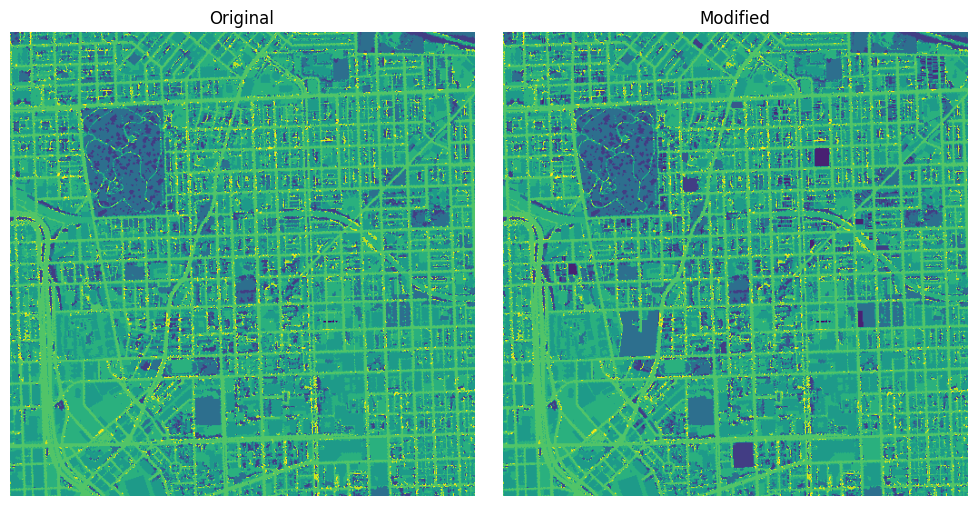

In [ ]:
input_tensor = torch.load(os.path.join(input_dir, optmz_site), weights_only=True).squeeze(1)
mod_tensor, num_modified = modify_input_channel(input_tensor, avail, avail_df, GI_type, x_prime)
# plot the original and the modified
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(input_tensor[0].numpy(), cmap='viridis')
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(mod_tensor[0].numpy(), cmap='viridis')
axs[1].set_title('Modified')
axs[1].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
input_tensor = torch.load(os.path.join(input_dir, optmz_site), weights_only=True).squeeze(1)
input_processed = load_single_sample(input_tensor, normalization_file=norm)
mod_tensor, num_modified = modify_input_channel(input_tensor, avail, avail_df, GI_type, x_prime)
mod_tensor_processed = load_single_sample(mod_tensor, normalization_file=norm)

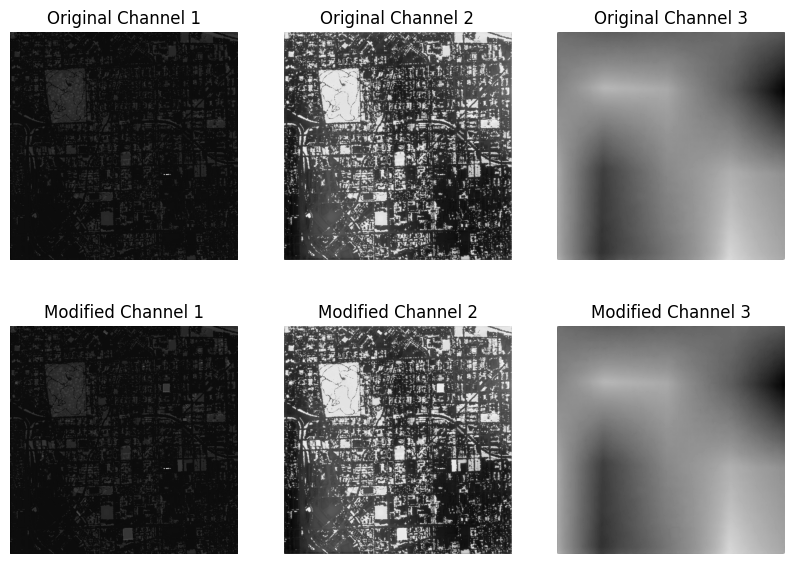

In [ ]:
model.eval()
# set random seed np
np.random.seed(0)
x_prime = np.random.randint(0, 5, len(avail_df))
with torch.no_grad():
    input_processed = load_single_sample(input_tensor, normalization_file=norm)
    output_orig = model(input_processed.unsqueeze(0))
    mod_tensor, num_modified = modify_input_channel(input_tensor, avail, avail_df, GI_type, x_prime)
    mod_tensor_processed = load_single_sample(mod_tensor, normalization_file=norm)
    output_mod = model(mod_tensor_processed.unsqueeze(0))

# plot the output
fig, axs = plt.subplots(2, 3, figsize=(10, 7))
for i in range(3):
    axs[0, i].imshow(output_orig[0, i].numpy(), cmap='gray')
    axs[0, i].set_title(f'Original Channel {i+1}')
    axs[0, i].axis('off')
    axs[1, i].imshow(output_mod[0, i].numpy(), cmap='gray')
    axs[1, i].set_title(f'Modified Channel {i+1}')
    axs[1, i].axis('off')

In [21]:
output_mod[0, 0].mean().item()

0.03301672264933586

In [ ]:
import torch.nn.functional as F
l = len(avail_df)
inptens = torch.load(os.path.join(input_dir, optmz_site), weights_only=True).squeeze(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device) 
model.eval()
# Define your custom problem
class LULCSurroOptProblem(ElementwiseProblem):
    def __init__(self, avail_df, avail, GI_type):
        
        self.avail_df = avail_df
        self.avail = avail
        self.GI_type = GI_type
        self.inptensor = inptens

        super().__init__(n_var=l, n_obj=4, 
                         n_constr=0, xl=0, xu=4, type_var=int)

    def _evaluate(self, x, out, *args, **kwargs):
        # Number of solutions
        x_prime = x
        mod_tensor, num_modified = modify_input_channel(self.inptensor, self.avail, self.avail_df, self.GI_type, x_prime)
        with torch.no_grad():
            mod_tensor_processed = load_single_sample(mod_tensor, normalization_file=norm).to(device)
            output_mod = model(mod_tensor_processed.unsqueeze(0))
        f1 = - output_mod[0, 0].mean().item()
        f2 = - output_mod[0, 1].mean().item()
        # sum the negative values of the third channel
        f3 = - torch.sum(output_mod[0, 2][(output_mod[0, 2] < 0) & (output_mod[0, 2] != float('-inf'))]).item()
        f4 = num_modified

        # Set the objective values
        out["F"] = [f1, f2, f3, f4]



problem = LULCSurroOptProblem(
    avail_df=avail_df,
    avail=avail,
    GI_type=GI_type,
)

# NSGA-II Algorithm setup
algorithm = NSGA2(
    pop_size=50,
    sampling=IntegerRandomSampling(),
    crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
    mutation=PM(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
    eliminate_duplicates=True
)

# Termination criterion
termination = get_termination("n_gen", 200)

In [ ]:
# Optimize the problem
res_sur = minimize(
    problem,
    algorithm,
    termination,
    seed=20,
    save_history=True,
    verbose=True
)

# Print results
import pickle
with open(sur_result, 'wb') as f:
    pickle.dump(res_sur, f)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       50 |     31 |             - |             -
     2 |      100 |     50 |  0.0438195711 |         ideal
     3 |      150 |     50 |  0.1180796211 |         ideal
     4 |      200 |     50 |  0.0181938472 |         ideal
     5 |      250 |     50 |  0.0514590524 |         nadir
     6 |      300 |     50 |  0.0277608298 |         ideal
     7 |      350 |     50 |  0.0326042097 |         ideal
     8 |      400 |     50 |  0.0157215623 |         ideal
     9 |      450 |     50 |  0.0239064051 |         ideal
    10 |      500 |     50 |  0.0181501975 |         nadir
    11 |      550 |     50 |  0.0468027211 |         ideal
    12 |      600 |     50 |  0.0353798127 |         ideal
    13 |      650 |     50 |  0.0086173162 |         ideal
    14 |      700 |     50 |  0.0227943869 |         ideal
    15 |      750 |     50 |  0.0533525400 |         ideal
    16 |      800 |     50 |  0.0313580247 |         ide

### Visualization (Surrogate-based)

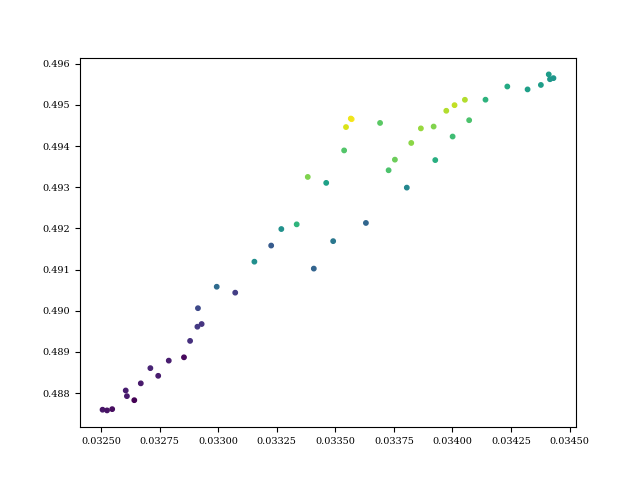

In [ ]:
# visualize the pareto 
import matplotlib.pyplot as plt
import numpy as np
import pickle
with open(sur_result, 'rb') as f:
    res_sur = pickle.load(f)

FF = res_sur.F * [-1, -1, -1, 1]
fig = plt.figure()
# 2d plot
plt.scatter(FF[:,0], FF[:,1], c=FF[:,2], s=10)
plt.show()

In [ ]:
# write back the surrogated results
res_sur.X[0]
res_load.X[0]
objective_values = []

# Reevaluate the objective values for each solution in the surrogate optimization using InVEST
def evaluateF (x):
        # Number of solutions
        x_prime = x
        num_modified = modify_lulc(lulc, avail, avail_df, GI_type, x_prime)
        # Objective values for each solution
        f1 = hq(lulc_mod, work_dir_hq, threats_p, sensitivity_p)
        f2 = ucm(lulc_mod, work_dir_ucm, aoi, et0, bio_csv)
        f3 = una(lulc_mod, work_dir_una, pop, aoi, attr_csv)
        f4 = num_modified

        # Set the objective values
        temp = [f1, f2, f3, f4]
        return temp

for x in res_sur.X:
    f = evaluateF(x)
    objective_values.append(f)

with open(sur_reeval, 'wb') as f:
    pickle.dump(objective_values, f)

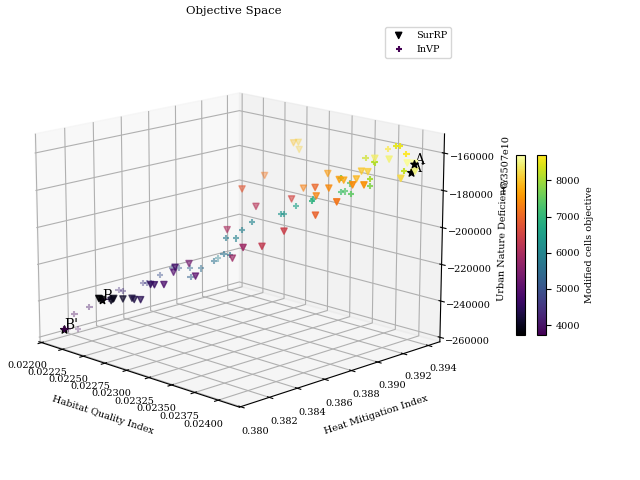

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

%matplotlib widget
# Sample data, replace F with your actual data
# change the font into cmu serif
with open(sur_reeval, 'rb') as f:
    objective_values = pickle.load(f)

matplotlib.rcParams['font.family'] = 'serif'
# font size
matplotlib.rcParams.update({'font.size': 7})

# Extracting the three dimensions
x = FF[:, 0]
y = FF[:, 1]
z = FF[:, 2] 

# Extracting the three dimensions
xi = FI[:, 0]
yi = FI[:, 1]
zi = FI[:, 2] 
ci = FI[:, 3]

FR = np.array(objective_values) * [-1, -1, -1, 1]

x_r = FR[:, 0]
y_r = FR[:, 1]
z_r = FR[:, 2] 
cr = FR[:, 3]

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scr = ax.scatter(x_r, y_r, z_r, c=cr, marker='v', label = 'SurRP', cmap='inferno')
sci = ax.scatter(xi, yi, zi, c=ci, marker='+', label = 'InVP', cmap='viridis')

# Add color bar

cbar2 = plt.colorbar(sci, ax=ax,  shrink=0.4, pad=-0.11)

# hide annotation of cbar 2

cbar1 = plt.colorbar(scr, ax=ax,  shrink=0.4, pad=0.1)
cbar1.ax.set_yticklabels([])
cbar1.ax.set_yticks([])

cbar2.set_label('Modified cells objective')  # Label for color bar


# HQI max
ax.scatter(x_r[6], y_r[6], z_r[6], c='black', marker='*', s=30, zorder=0.1)
ax.text(x_r[6], y_r[6], z_r[6], 'A', color='black', fontsize=10)
ax.scatter(xi[1], yi[1], zi[1], c='black', marker=r'$\star$', s=30, zorder=0.1)
ax.text(xi[1], yi[1], zi[1], 'A\'', color='black', fontsize=10)

# min convert
ax.scatter(x_r[0], y_r[0], z_r[0], c='black', marker='*', s=30, zorder=0.1)
ax.text(x_r[0], y_r[0], z_r[0], 'B', color='black', fontsize=10)
ax.scatter(xi[6], yi[6], zi[6], c='black', marker=r'$\star$', s=30, zorder=0.1)
ax.text(xi[6], yi[6], zi[6], 'B\'', color='black', fontsize=10)

# Set labels for each axis
ax.set_xlabel('Habitat Quality Index')
ax.set_ylabel('Heat Mitigation Index')
ax.set_zlabel('Urban Nature Deficiency')

ax.legend(loc='upper right') 


# Set title
ax.set_title('Objective Space')
ax.view_init(elev=15, azim=-45)
plt.tight_layout()
# Show the plot
plt.show()
# save to svg
# plt.savefig('E:/Coding/CNN_InV/Figure/PFcomparison_reevonly+ori.svg', format='svg', dpi=1200)
# plt.savefig('E:/Coding/CNN_InV/Figure/0205PFmark.jpg', format='jpg', dpi=600)

# Pareto analysis

### GD & IGD

In [60]:
from pymoo.indicators.gd import GD
import numpy as np

def min_max_normalize(FR, FI):
    """
    Normalize each objective separately using a shared min-max scale.
    Ensures that FR and FI are normalized consistently across each objective.
    """
    FR_norm = np.zeros_like(FR)
    FI_norm = np.zeros_like(FI)

    for i in range(FR.shape[1]):  # Loop over each objective
        obj_min = min(FR[:, i].min(), FI[:, i].min())  # Global min across FR & FI
        obj_max = max(FR[:, i].max(), FI[:, i].max())  # Global max across FR & FI
        
        obj_range = obj_max - obj_min
        if obj_range == 0:
            obj_range = 1  # Prevent division by zero if all values are the same
        
        FR_norm[:, i] = (FR[:, i] - obj_min) / obj_range
        FI_norm[:, i] = (FI[:, i] - obj_min) / obj_range

    return FR_norm, FI_norm

# Normalize using a shared scale
FR_norm, FI_norm = min_max_normalize(FR, FI)
ind = GD(FI_norm)
print(ind(FR_norm))

0.10755931588822339


In [ ]:
from pymoo.indicators.igd import IGD
ind = IGD(FI_norm)
print(ind(FR_norm))

0.09027419413802962


### Re-Non-dominated sorting

In [ ]:
def pareto_filter(FR, FI):
    """
    Combine two sets of solutions (FR and FI) and filter out dominated ones.
      - objectives 1,2,3 are to be maximized
      - objective 4 is to be minimized (so we multiply by -1)
    Returns:
      - final_solutions: the original (untransformed) objective vectors of non-dominated solutions
      - sources: an array of the same length with labels 'FR' or 'FI'
      - idx_final: indices (in the combined list) of non-dominated solutions (optional)
    """
    # Transform objectives so that all are maximized
    # first 3 stay the same, fourth multiplied by -1.
    FR_obj = np.column_stack((FR[:, 0], FR[:, 1], FR[:, 2], -FR[:, 3]))
    FI_obj = np.column_stack((FI[:, 0], FI[:, 1], FI[:, 2], -FI[:, 3]))
    
    # Combine both sets
    combined_obj = np.vstack((FR_obj, FI_obj))
    combined_orig = np.vstack((FR, FI))

    # Mark which solution comes from which approach
    sources = np.array(['FR'] * FR.shape[0] + ['FI'] * FI.shape[0])
    n = combined_obj.shape[0]
    dominated = np.zeros(n, dtype=bool)
    
    # Check each solution against every other solution.
    # A solution i is dominated if there exists any solution j such that:
    #    for all objectives:  j_obj >= i_obj  AND at least one j_obj > i_obj.
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            if np.all(combined_obj[j] >= combined_obj[i]) and np.any(combined_obj[j] > combined_obj[i]):
                dominated[i] = True
                break  # no need to check further if i is already dominated
                
    # Select the non-dominated solutions.
    idx_final = np.where(~dominated)[0]
    final_solutions = combined_orig[idx_final, :]
    final_sources = sources[idx_final]
    
    return final_solutions, final_sources, idx_final


# Filter the Combined Pareto Set

final_solutions, final_sources, idx_final = pareto_filter(FR, FI)

# Print counts from each approach
count_FR = np.sum(final_sources == 'FR')
count_FI = np.sum(final_sources == 'FI')

# Plot the Final Pareto Set

# Assume the objectives are:
#   Column 0: x-axis
#   Column 1: y-axis
#   Column 2: z-axis
#   Column 3: used for color mapping

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Separate the solutions based on their source
final_FR = final_solutions[final_sources == 'FR']
final_FI = final_solutions[final_sources == 'FI']

# Plot FR final solutions using one marker style
if final_FR.size > 0:
    sc1 = ax.scatter(final_FR[:, 0], final_FR[:, 1], final_FR[:, 2],
                     c=final_FR[:, 3], marker='.', s=50, label='SurRP (Final)')

# Plot FI final solutions using a different marker style
if final_FI.size > 0:
    sc2 = ax.scatter(final_FI[:, 0], final_FI[:, 1], final_FI[:, 2],
                     c=final_FI[:, 3], marker='+', s=80, label='InVP (Final)')

cbar = plt.colorbar(sc2, ax=ax, shrink=0.4, pad=0.1)
cbar.set_label('Modified cells objective')
ax.set_xlabel('Habitat Quality Index')
ax.set_ylabel('Heat Mitigation Index')
ax.set_zlabel('Urban Nature Deficiency')
ax.set_title('Combined Pareto Solutions (After Filtering)')
ax.view_init(elev=15, azim=-45)
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


### Trade-off Analysis

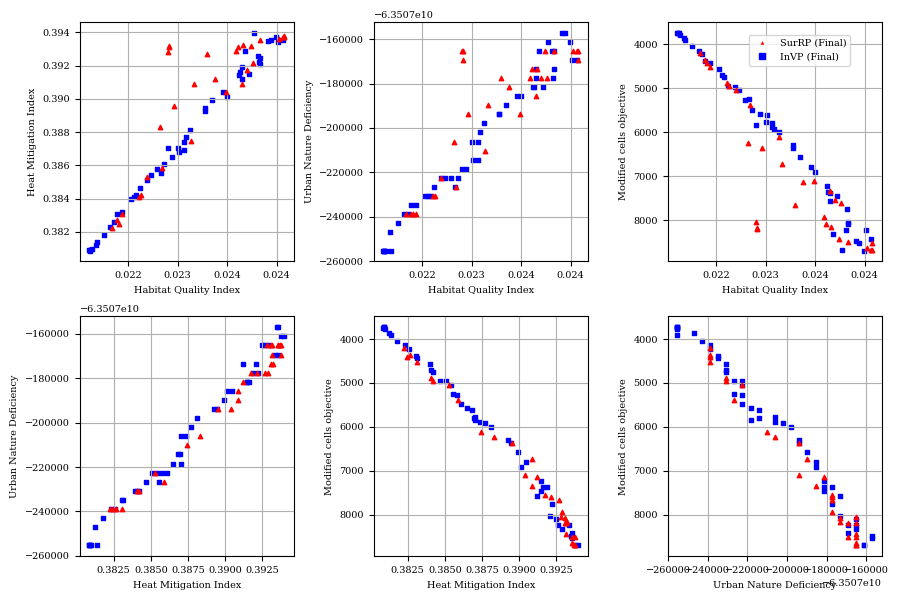

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter  #

# Assuming final_solutions and final_sources are defined
final_FR = final_solutions[final_sources == 'FR']
final_FI = final_solutions[final_sources == 'FI']

# Define labels for each dimension
labels = [
    'Habitat Quality Index',
    'Heat Mitigation Index',
    'Urban Nature Deficiency',
    'Modified cells objective'
]

# Create figure and subplots
fig, axs = plt.subplots(2, 3, figsize=(9, 6))
axs = axs.ravel()

# Define all pairwise combinations (0-based indices)
combinations = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

# Determine global color limits
all_color = []
if final_FR.size > 0:
    all_color.append(final_FR[:, 3])
if final_FI.size > 0:
    all_color.append(final_FI[:, 3])
vmin = np.min(np.concatenate(all_color)) if all_color else 0
vmax = np.max(np.concatenate(all_color)) if all_color else 1

# Plot each combination
for idx, (x_col, y_col) in enumerate(combinations):
    ax = axs[idx]
    
    # Plot FR data
    if final_FR.size > 0:
        sc1 = ax.scatter(
            final_FR[:, x_col], final_FR[:, y_col],
            c='red', marker='^', s=10,
            label='SurRP (Final)', zorder = 2
        )
    
    # Plot FI data
    if final_FI.size > 0:
        sc2 = ax.scatter(
            final_FI[:, x_col], final_FI[:, y_col],
            c='blue', marker='s', s=5,
            label='InVP (Final)'
        )
    
    # Set axis labels
    ax.set_xlabel(labels[x_col])
    ax.set_ylabel(labels[y_col])
    if x_col == 0:
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    if y_col == 0:
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    if x_col == 3:
        ax.invert_xaxis()
    if y_col == 3:
        ax.invert_yaxis()
    ax.grid(True)

# Add a unified legend
handles = []
if final_FR.size > 0:
    handles.append(plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='r', 
                              markersize=5, label='SurRP (Final)'))
if final_FI.size > 0:
    handles.append(plt.Line2D([0], [0], marker='s', color='b', linewidth=0,
                              markersize=5, label='InVP (Final)'))
if handles:
    fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(0.95, 0.95))

plt.tight_layout()
# plt.savefig('Trade-off.jpg', format='jpg', dpi=600)

### Anchor point analysis

In [ ]:
# identify anchor points. Identify index of r and i 
index_f1r = np.where(x_r == np.max(x_r))[0]
index_f2r = np.where(y_r == np.max(y_r))[0]
index_f3r = np.where(z_r == np.max(z_r))[0]
index_f4r = np.where(cr == np.min(cr))[0]
# print(index_f1r, index_f2r, index_f3r, index_f4r)
index_f1i = np.where(xi == np.max(xi))[0]
index_f2i = np.where(yi == np.max(yi))[0]
index_f3i = np.where(zi == np.min(zi))[0]
index_f4i = np.where(ci == np.min(ci))[0]
# print(index_f1i, index_f2i, index_f3i, index_f4i)

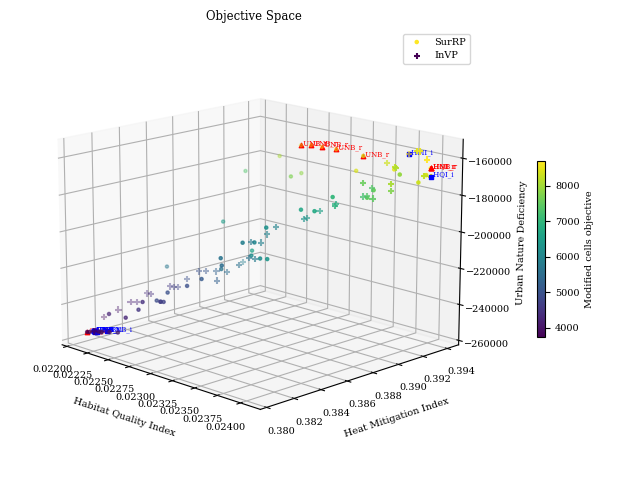

In [49]:
# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the scatter plot
scr = ax.scatter(x_r, y_r, z_r, c=cr, marker='.', label='SurRP')
sci = ax.scatter(xi, yi, zi, c=ci, marker='+', label='InVP')

# Add color bar for one of the datasets (example for InVP)
cbar2 = plt.colorbar(sci, ax=ax, shrink=0.4, pad=0.1)
cbar2.set_label('Modified cells objective')

# Function to annotate a set of indices
def annotate_points(indices, x_data, y_data, z_data, label_text, color, marker_style):
    for idx in indices:
        # Highlight the point with an additional marker
        ax.scatter(x_data[idx], y_data[idx], z_data[idx],
                   color=color, marker=marker_style, s=10)
        # Add a text label next to the point
        ax.text(x_data[idx], y_data[idx], z_data[idx],
                f' {label_text}', color=color, fontsize=5)

# Annotate SurRP points
annotate_points(index_f1r, x_r, y_r, z_r, 'HQI_r', 'red', '^')
annotate_points(index_f2r, x_r, y_r, z_r, 'HMI_r', 'red', '^')
annotate_points(index_f3r, x_r, y_r, z_r, 'UNB_r', 'red', '^')
annotate_points(index_f4r, x_r, y_r, z_r, 'CR_r', 'red', '^')

# Annotate InVP points
annotate_points(index_f1i, xi, yi, zi, 'HQI_i', 'blue', 's')
annotate_points(index_f2i, xi, yi, zi, 'HMI_i', 'blue', 's')
annotate_points(index_f3i, xi, yi, zi, 'UNB_i', 'blue', 's')
annotate_points(index_f4i, xi, yi, zi, 'CR_i', 'blue', 's')

# Set labels for each axis
ax.set_xlabel('Habitat Quality Index')
ax.set_ylabel('Heat Mitigation Index')
ax.set_zlabel('Urban Nature Deficiency')

# Add legend (note: the additional markers may not automatically appear in the legend)
ax.legend(loc='upper right')

# Set title and adjust the view
ax.set_title('Objective Space')
ax.view_init(elev=15, azim=-45)
plt.tight_layout()

plt.show()

In [ ]:
# pair-wise comparison
res_sur.X[0]
res_load.X[0]

def modify_array(lulc, avail, avail_df, GI_type, x_prime):
    avail_values = avail_df.iloc[:, 0].tolist()
    avail_np = avail.values
    lulc_np = lulc.values.copy() 
    x = np.array([GI_type[i] for i in x_prime])
        # Iterate over each group and modify lulc accordingly
    for i, avail_val in enumerate(avail_values):
        gi_val = x[i]
        if gi_val != 0:
            # Update lulc where the avail mask equals the current group value
            lulc_np[avail_np == avail_val] = gi_val
    modified_lulc = xr.DataArray(
            lulc_np,
            coords=lulc.coords,
            dims=lulc.dims,
            attrs=lulc.attrs
        )
    modified_lulc.rio.to_raster(lulc_mod)
    # count the number of pixels that have been modified
    modified_pixels = np.sum(modified_lulc != lulc).item()
    # print(f"Modified {modified_pixels} pixels.")
    return modified_lulc, modified_pixels

def evaluateplot (x):
        # Number of solutions
        x_prime = x
        modified_lulc, num_modified = modify_array(lulc, avail, avail_df, GI_type, x_prime)
        # Objective values for each solution
        f1 = hq(lulc_mod, work_dir_hq, threats_p, sensitivity_p)
        f2 = ucm(lulc_mod, work_dir_ucm, aoi, et0, bio_csv)
        f3 = una(lulc_mod, work_dir_una, pop, aoi, attr_csv)
        f4 = num_modified * 25

        # Set the objective values
        temp = [f1, f2, f3, f4]
        return temp, modified_lulc

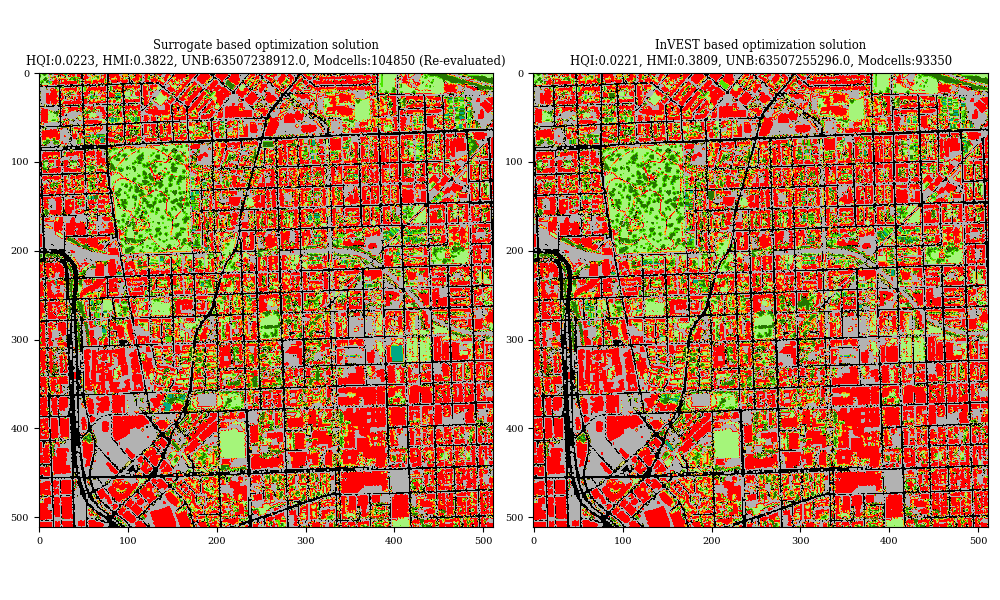

In [ ]:
import matplotlib.colors as mcolors

def plot_evaluation_with_modified_lulc(res_sur, res_load, evaluateplot, inds, indi):
    """
    Plot two subplots: one with the modified LULC from res_sur.X[0] and 
    the other with the modified LULC from res_load.X[0].
    Annotate the mean performance values f1, f2, f3 for each, and display
    specific values in the array with specific colors.
    
    Parameters:
    - res_sur: rioxarray dataset for the first modified LULC subplot
    - res_load: rioxarray dataset for the second modified LULC subplot
    - evaluateplot: function to evaluate and modify lulc
    """
    # Get modified LULC and objectives for res_sur.X[0]
    temp_sur, modified_lulc_sur = evaluateplot(res_sur.X[inds])

    # Get modified LULC and objectives for res_load.X[0]
    temp_inv, modified_lulc_load = evaluateplot(res_load.X[indi])

    # Define custom colors and bounds based on the CLR content
    cmap_colors = [
        (0 / 255.0, 97 / 255.0, 255 / 255.0),      # Water
        (0 / 255.0, 168 / 255.0, 132 / 255.0),     # Emergent Wetlands
        (38 / 255.0, 115 / 255.0, 0 / 255.0),      # Tree Canopy
        (76 / 255.0, 230 / 255.0, 0 / 255.0),      # Scrub/Shrub
        (165 / 255.0, 245 / 255.0, 122 / 255.0),   # Low Vegetation
        (255 / 255.0, 170 / 255.0, 0 / 255.0),     # Barren
        (255 / 255.0, 0 / 255.0, 0 / 255.0),       # Impervious Structures
        (178 / 255.0, 178 / 255.0, 178 / 255.0),   # Other Impervious
        (0 / 255.0, 0 / 255.0, 0 / 255.0),         # Impervious Roads
        (115 / 255.0, 115 / 255.0, 0 / 255.0),     # Tree Canopy Over Structures
        (205 / 255.0, 205 / 255.0, 102 / 255.0),   # Tree Canopy Over Other Impervious
        (255 / 255.0, 255 / 255.0, 115 / 255.0),   # Tree Canopy Over Impervious Roads
        (197 / 255.0, 0 / 255.0, 255 / 255.0)      # Aberdeen Proving Ground
    ]

    # Create the ListedColormap and BoundaryNorm
    cmap = mcolors.ListedColormap(cmap_colors)
    bounds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 254, 255]  # Corresponding bounds for the values
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Plot the results
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))

    # Plot modified LULC for res_sur.X[0]
    ax = axes[0]
    data1 = modified_lulc_sur.values
    im1 = ax.imshow(data1, cmap=cmap, norm=norm)
    ax.set_title(f'Surrogate based optimization solution\n'
                 f'HQI:{-temp_sur[0]:.4f}, HMI:{-temp_sur[1]:.4f}, UNB:{temp_sur[2]}, Modcells:{temp_sur[3]} (Re-evaluated)')
 

    # Plot modified LULC for res_load.X[0]
    ax = axes[1]
    data2 = modified_lulc_load.values
    im2 = ax.imshow(data2, cmap=cmap, norm=norm)
    ax.set_title(f'InVEST based optimization solution\n'
                 f'HQI:{-temp_inv[0]:.4f}, HMI:{-temp_inv[1]:.4f}, UNB:{temp_inv[2]}, Modcells:{temp_inv[3]}')

    # save the figure as pdf
    # plt.savefig(f'0205GIalloComp_{indi}{inds}.jpg', format='jpg', dpi=1200)
    plt.tight_layout()
    plt.show()

plot_evaluation_with_modified_lulc(res_sur, res_load, evaluateplot, 0, 6)